In [1]:
import graph_tool as gt
import torch
import pickle
from src.diffusion_model_discrete import DiscreteDenoisingDiffusion
from sample import get_model_sbm
from src.diffusion import diffusion_utils
import networkx as nx
import matplotlib.pyplot as plt
from src.analysis.visualization import NonMolecularVisualization
import torch.nn.functional as F
import numpy as np

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::pair<double, double> already registered; second conversion method ignored.


In [2]:
model = get_model_sbm()
visualizer = NonMolecularVisualization()


(ipykernel_launcher.py:71827): Gtk-WARNING **: 00:58:54.368: Locale not supported by C library.
	Using the fallback 'C' locale.
/home/renyi/anaconda3/envs/digress/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Marginal distribution of the classes: tensor([1.]) for nodes, tensor([0.9156, 0.0844]) for edges


In [3]:
def flip_random_bit(gt_placeholder, bs = 1):
    # in place flip a random bit
    n = gt_placeholder.X.size(1)
    for t in range(bs):
        i = np.random.randint(0, n-1)
        j = np.random.randint(i+1, n)
       # print( gt_placeholder.E[0, i, j, : ], gt_placeholder.E[0, j, i, : ])
        gt_placeholder.E[0, i, j, : ] = 1 - gt_placeholder.E[0, i, j, :]
        gt_placeholder.E[0, j, i, : ] = 1 - gt_placeholder.E[0, j, i, :]
    return gt_placeholder


In [3]:
G_t = model.sample_G_T()
G_prime = model.sample_G_T()
print(G_prime.X.size())
print(G_t.X.size())
# assert not equal
#G_prime = flip_random_bit(G_prime)
assert not torch.equal(G_prime.E, G_t.E)

torch.Size([1, 123, 1])
torch.Size([1, 91, 1])


In [19]:
_, e1 = model.sample_one(G_t.copy(), deterministic=True)
_, e2 = model.sample_one(G_t.copy(), deterministic=True)

assert torch.equal(e2, e1)

In [11]:
def Jaccard_Similarity( e1, e2):
    intersection = np.sum(np.logical_and(e1, e2))
    union = np.sum(np.logical_or(e1, e2))
    if union == 0:  
        return 1.0 
    jaccard_similarity = intersection / union
    
    return jaccard_similarity

In [28]:
G_t = model.sample_G_T()
n = G_t.get_node_amount()
G_prime = model.sample_G_T(n_nodes=torch.tensor([n]))
G_prime.E = torch.tensor([1, 0]).repeat(n, n , 1).unsqueeze(0).to('cuda')
print("source diff:", torch.sum(torch.abs(G_prime.E - G_t.E)))

source diff: tensor(1502., device='cuda:0')


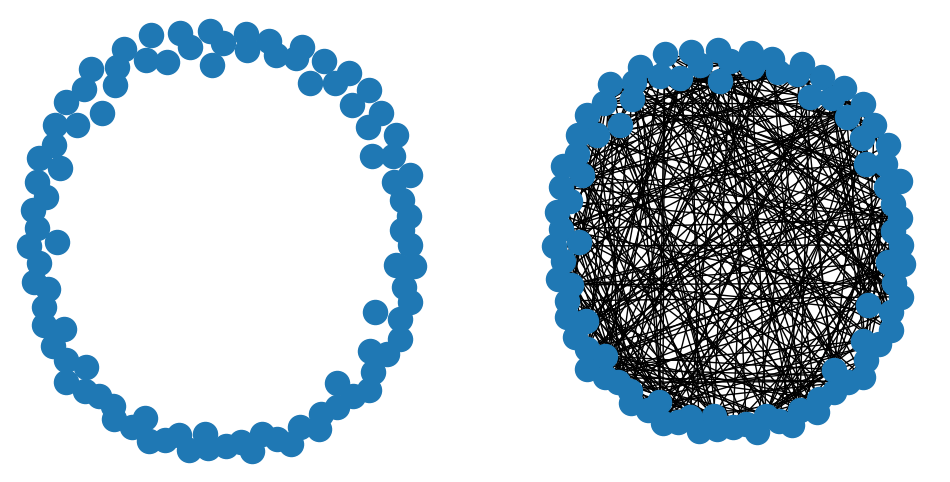

In [31]:
G1 = nx.from_numpy_matrix(G_prime.E.cpu().argmax(-1).numpy().squeeze(0))
pos = nx.spring_layout(G1, seed=42)
G2 = nx.from_numpy_matrix(G_t.E.cpu().argmax(-1).numpy().squeeze(0))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
nx.draw(G1, pos, ax=axes[0])
nx.draw(G2, pos, ax=axes[1])

In [32]:

G_0_np = model.sample_one(G_t.copy())[1].squeeze(0).numpy()
G_0_prime_np = model.sample_one(G_prime.copy())[1].squeeze(0).numpy()
print("target diff: ", np.sum(np.abs(G_0_prime_np - G_0_np)))


KeyboardInterrupt: 

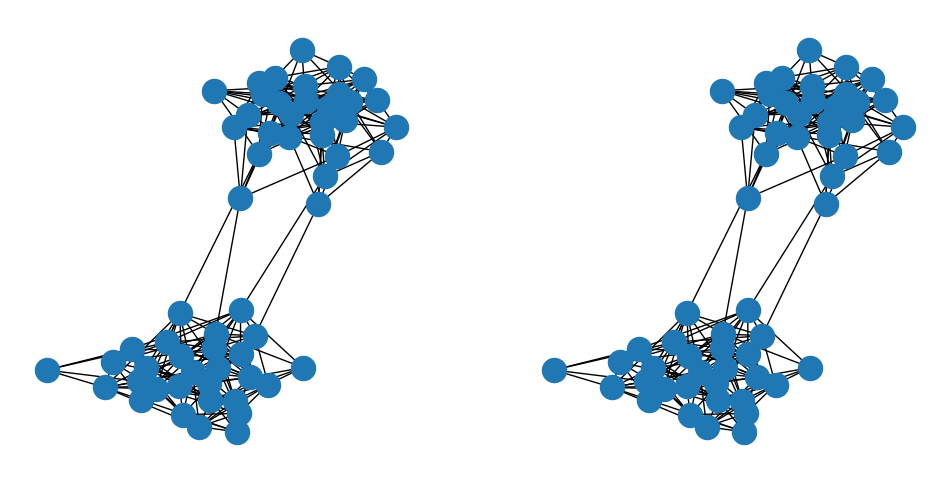

In [25]:

G1 = nx.from_numpy_matrix(G_0_np)
pos = nx.spring_layout(G1, seed=42)
G2 = nx.from_numpy_matrix(G_0_prime_np)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
nx.draw(G1, pos, ax=axes[0])
nx.draw(G2, pos, ax=axes[1])

In [ ]:
iter = 20
for i in range(iter):
    G_prime = flip_random_bit(G_prime, bs = 1000)
    assert not torch.equal(G_prime.E, G_t.E)
    G_0_prime_np = model.sample_one(G_prime)[1].squeeze(0).numpy()
    print("source diff:", torch.sum(torch.abs(G_prime.E - G_t.E)))
    print(Jaccard_Similarity(G_0_prime_np, G_0_np))
    print("target diff: ", np.sum(np.abs(G_0_prime_np - G_0_np)))

source diff: tensor(3456., device='cuda:0')
1.0
target diff:  0
source diff: tensor(6376., device='cuda:0')
1.0
target diff:  0
source diff: tensor(8880., device='cuda:0')
1.0
target diff:  0
source diff: tensor(10920., device='cuda:0')
1.0
target diff:  0
source diff: tensor(12664., device='cuda:0')
1.0
target diff:  0
source diff: tensor(14232., device='cuda:0')
1.0
target diff:  0
source diff: tensor(15704., device='cuda:0')
1.0
target diff:  0
source diff: tensor(16912., device='cuda:0')
1.0
target diff:  0
source diff: tensor(18128., device='cuda:0')
1.0
target diff:  0
source diff: tensor(19376., device='cuda:0')
1.0
target diff:  0


In [10]:
#

0.9555066079295155
0.9550660792951542
0.9546455306032585
0.954225352112676
0.9538055433347998
0.9533861037818822
0.952967032967033
0.9525483304042179
0.9521299956082565
0.95171202809482
0.95129442738043
0.95171202809482
0.95129442738043
0.9508771929824561
0.9504603244191144
0.9500438212094654
0.9496276828734121
0.9491896627244854
0.9487740805604203
0.9483588621444201
0.9479440069991251
0.9475295146480105
0.9471153846153846
0.9467016164263871
0.9462882096069869
0.9458751636839808
0.9454624781849913
0.9450261780104712
0.9446140427387701
0.944202266782912
0.9437663469921534
0.9433551198257081
0.9429442508710801
0.9425337396604266
0.9421235857267188
0.9417137886037408
0.941304347826087
0.9408952629291613
0.9404865334491747
0.9400781589231437
0.9396701388888888
0.9392624728850325
0.9388551604509974
0.9384482011270048
0.9380415944540728
0.9376353399740147
0.9372022520571676
0.9367965367965368
0.9363911726525314
0.9359861591695502
0.93558149589278
0.9351771823681936
0.9347732181425485
0.93436